In [1]:

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


In [2]:
# Setting Kaggle configuration
os.environ['KAGGEL_CONFIG_DIR'] = '/content/kaggle.json'
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d harishkumardatalab/food-image-classification-dataset

 99% 1.67G/1.68G [00:17<00:00, 118MB/s]
100% 1.68G/1.68G [00:17<00:00, 102MB/s]


In [4]:
!unzip \*.zip

Streaming output truncated to the last 5000 lines.
  inflating: Food Classification dataset/idli/277.jpg  
  inflating: Food Classification dataset/idli/278.jpg  
  inflating: Food Classification dataset/idli/280.jpg  
  inflating: Food Classification dataset/idli/282.jpg  
  inflating: Food Classification dataset/idli/283.jpg  
  inflating: Food Classification dataset/idli/284.jpg  
  inflating: Food Classification dataset/idli/285.jpg  
  inflating: Food Classification dataset/idli/286.jpg  
  inflating: Food Classification dataset/idli/287.jpg  
  inflating: Food Classification dataset/idli/288.jpg  
  inflating: Food Classification dataset/idli/290.jpg  
  inflating: Food Classification dataset/idli/292.jpg  
  inflating: Food Classification dataset/idli/293.jpg  
  inflating: Food Classification dataset/idli/295.jpg  
  inflating: Food Classification dataset/idli/296.jpg  
  inflating: Food Classification dataset/idli/297.jpg  
  inflating: Food Classification dataset/idli/299.jpg

In [5]:
# Creating a directory for the processed data
import shutil
path = "/content/Food Classification dataset"
# os.mkdir(path)

In [6]:
# to fix some of the extension of images as errors recived during training
from PIL import Image
import os

def convert_images_to_jpg(input_dir):
    # Loop through each folder in the input directory
    for folder_name in os.listdir(input_dir):
        folder_path = os.path.join(input_dir, folder_name)

        # Check if it's a directory
        if os.path.isdir(folder_path):
            # Loop through each image in the folder
            for file_name in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file_name)

                # Check if it's a file and has a supported image format
                if os.path.isfile(file_path) and any(file_name.lower().endswith(ext) for ext in ['.jpg', '.png', '.gif', '.bmp']):
                    # Exclude files with the extension ".jpeg"
                    if not file_name.lower().endswith('.jpeg'):
                        # Open the image and save it in JPEG format (overwriting the original)
                        img = Image.open(file_path)
                        img.convert("RGB").save(file_path, "JPEG")

if __name__ == "__main__":
    input_directory = "/content/Food Classification dataset"
    convert_images_to_jpg(input_directory)


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [7]:
# Retrieving class names based on subdirectory names
class_names = sorted(os.listdir(path))

In [8]:
print(class_names)

['Baked Potato', 'Crispy Chicken', 'Donut', 'Fries', 'Hot Dog', 'Sandwich', 'Taco', 'Taquito', 'apple_pie', 'burger', 'butter_naan', 'chai', 'chapati', 'cheesecake', 'chicken_curry', 'chole_bhature', 'dal_makhani', 'dhokla', 'fried_rice', 'ice_cream', 'idli', 'jalebi', 'kaathi_rolls', 'kadai_paneer', 'kulfi', 'masala_dosa', 'momos', 'omelette', 'paani_puri', 'pakode', 'pav_bhaji', 'pizza', 'samosa', 'sushi']


In [9]:
import tensorflow as tf

# Load the image using TensorFlow I/O
image_path = '/content/Food Classification dataset/Fries/Fries-Train (10).jpeg'
image = tf.io.read_file(image_path)
image = tf.image.decode_image(image, channels=3)  # Assuming RGB image

# Get the height and width of the image
height, width = image.shape[0], image.shape[1]

print(f"Image Height: {height}, Image Width: {width}")


Image Height: 285, Image Width: 177


In [10]:
batch_size = 32
img_height = 128
img_width = 128

In [11]:
# Creating a data generator for the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)# Creating a data generator for the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 23873 files belonging to 34 classes.
Using 19099 files for training.
Found 23873 files belonging to 34 classes.
Using 4774 files for validation.


In [12]:
# Displaying class names
print(class_names)


['Baked Potato', 'Crispy Chicken', 'Donut', 'Fries', 'Hot Dog', 'Sandwich', 'Taco', 'Taquito', 'apple_pie', 'burger', 'butter_naan', 'chai', 'chapati', 'cheesecake', 'chicken_curry', 'chole_bhature', 'dal_makhani', 'dhokla', 'fried_rice', 'ice_cream', 'idli', 'jalebi', 'kaathi_rolls', 'kadai_paneer', 'kulfi', 'masala_dosa', 'momos', 'omelette', 'paani_puri', 'pakode', 'pav_bhaji', 'pizza', 'samosa', 'sushi']


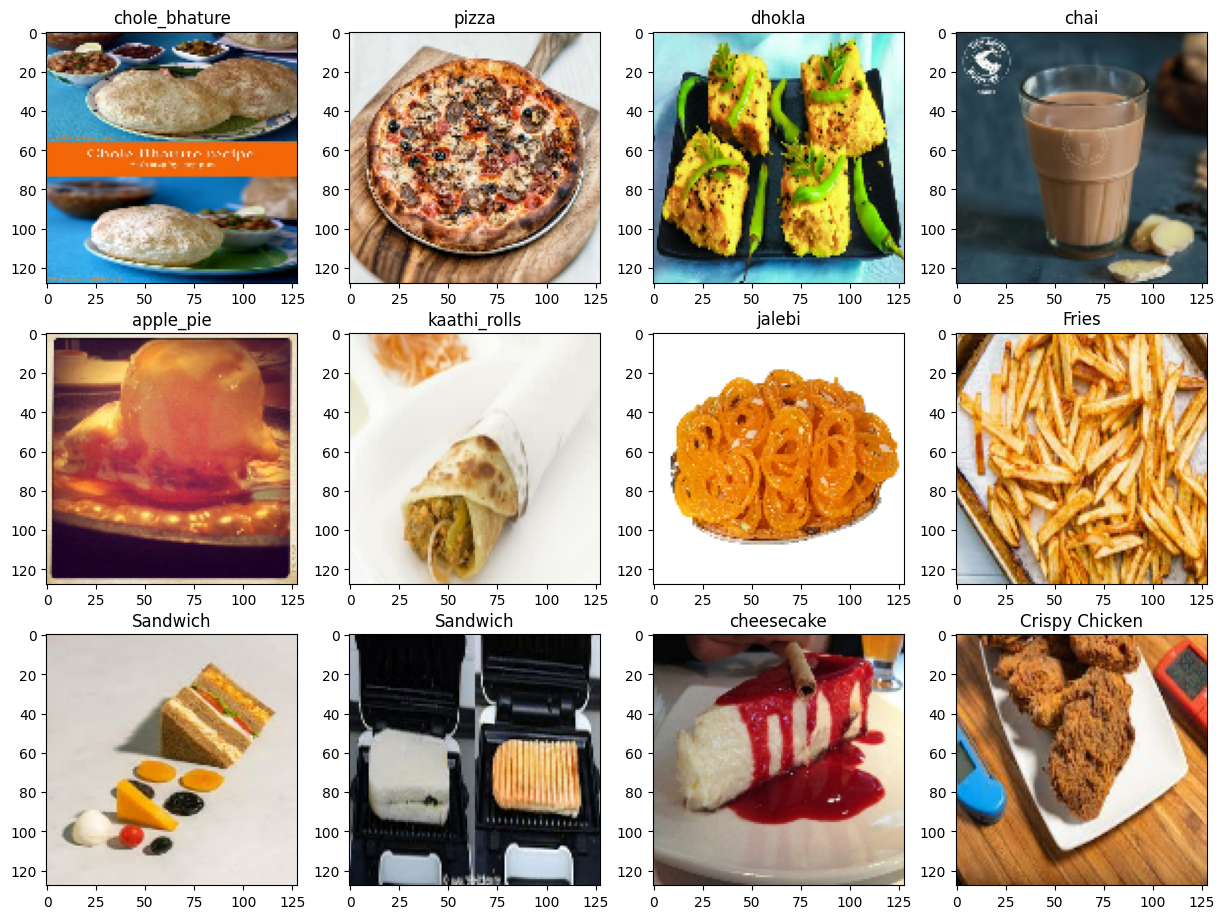

In [13]:
# Displaying a sample of images from the training dataset
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(min(12, len(images))):
      ax = plt.subplot(4, 4, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("on")

In [14]:
# Checking the shape of an image batch and labels batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


In [15]:
# Normalizing pixel values to the range [0,1]
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [17]:
data_augmentation1 = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
    input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)
data_augmentation2 = keras.Sequential(
  [
    layers.RandomFlip("vertical",
    input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
  ]
)
data_augmentation3 = keras.Sequential(
    [
        layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
        layers.RandomRotation(0.3),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
        layers.RandomBrightness(0.1),
        # layers.RandomSaturation(0.1),
        layers.GaussianNoise(0.1),
        # layers.Rescaling(1./255),
    ]
)

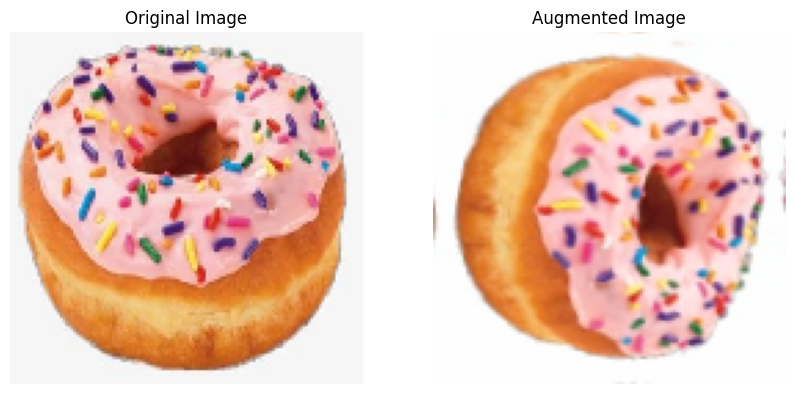

In [18]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Replace this path with the actual path to your image file
image_path = '/content/Food Classification dataset/Donut/Donut (1).png'

# Load the image from file
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
image_array = tf.keras.preprocessing.image.img_to_array(image)

# Define the data augmentation pipeline
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
        layers.RandomRotation(0.3),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
        layers.RandomBrightness(0.1),
        # layers.RandomSaturation(0.1),
        layers.GaussianNoise(0.1),
        # layers.Rescaling(1./255),
    ]
)

# Apply data augmentation to the image
augmented_image = data_augmentation(tf.expand_dims(image_array, 0), training=True)

# Display original and augmented images
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image_array.astype("uint8"))
plt.title("Original Image")
plt.axis("off")

# Augmented image
plt.subplot(1, 2, 2)
plt.imshow(augmented_image[0].numpy().astype("uint8"))
plt.title("Augmented Image")
plt.axis("off")

plt.show()


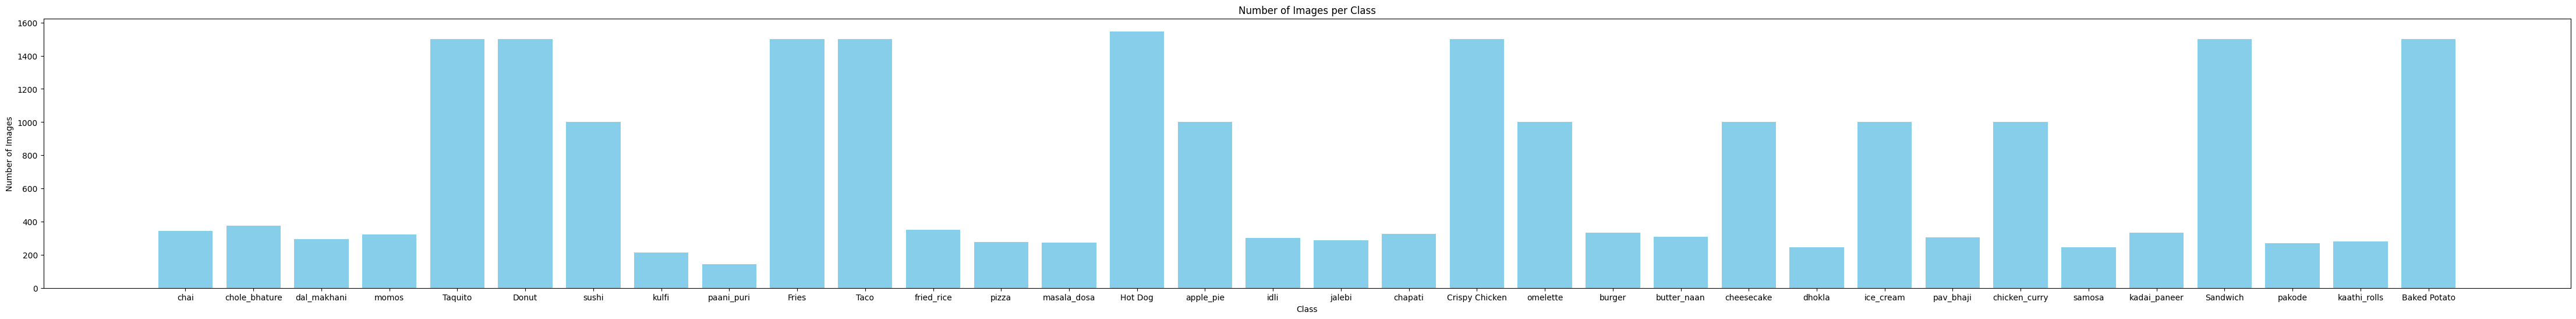

In [ ]:
# @title
import os
import matplotlib.pyplot as plt

# Replace this with the path to your dataset
dataset_path = '/content/Food Classification dataset'

# List all class folders in the dataset directory
class_folders = [folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))]

# Count the number of images in each class folder
num_images_per_class = []
for folder in class_folders:
    class_path = os.path.join(dataset_path, folder)
    num_images = len(os.listdir(class_path))
    num_images_per_class.append(num_images)

# Plotting the bar graph
plt.figure(figsize=(56, 6))
plt.bar(class_folders, num_images_per_class, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.show()


In [ ]:
# after multiple trys of diffrent modles with diffrent layers and number of filter numbers this is what we went with
import tensorflow as tf
model = Sequential([

  data_augmentation1,
  data_augmentation2,
  layers.Conv2D(224, (4, 4), padding="same", activation="relu"),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(120, (3, 3), padding="same", activation="relu"),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(70, (3, 3), padding="same", activation="relu"),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(50, (3, 3), padding="same", activation="relu"),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Flatten(),
  layers.Dense(34, activation="softmax")

])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 128, 128, 224)     10976     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 64, 64, 224)       0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 120)       242040    
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 32, 32, 120)       0         
 ng2D)                                                

In [ ]:
# default learning rate for Adam in Keras is typically set to 0.001.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
597/597 [==============================] - 61s 97ms/step - loss: 3.5927 - accuracy: 0.0902 - val_loss: 3.1341 - val_accuracy: 0.0984
Epoch 2/15
597/597 [==============================] - 58s 96ms/step - loss: 3.0717 - accuracy: 0.1170 - val_loss: 3.0286 - val_accuracy: 0.1320
Epoch 3/15
597/597 [==============================] - 57s 95ms/step - loss: 2.9919 - accuracy: 0.1384 - val_loss: 2.9831 - val_accuracy: 0.1374
Epoch 4/15
597/597 [==============================] - 56s 94ms/step - loss: 2.8591 - accuracy: 0.1730 - val_loss: 2.8146 - val_accuracy: 0.1902
Epoch 5/15
597/597 [==============================] - 58s 97ms/step - loss: 2.7576 - accuracy: 0.2038 - val_loss: 2.7288 - val_accuracy: 0.2128
Epoch 6/15
597/597 [==============================] - 57s 94ms/step - loss: 2.6758 - accuracy: 0.2257 - val_loss: 2.7071 - val_accuracy: 0.2310
Epoch 7/15
597/597 [==============================] - 57s 95ms/step - loss: 2.6094 - accuracy: 0.2472 - val_loss: 2.7629 - val_accuracy:

In [21]:
# Assignment Experiments 1
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers

num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    data_augmentation1,

    layers.Conv2D(224, 3, padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(120, 3, padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(70, 3, padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(50, 3, padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256),
    layers.Activation('relu'),

    layers.Dense(num_classes, activation='softmax')  # Added softmax activation for classification
])

learning_rate = 1  # Set learning rate
optimizer = optimizers.SGD(learning_rate=learning_rate)  # SGD with specified learning rate

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 224)     6272      
                                                                 
 activation_5 (Activation)   (None, 128, 128, 224)     0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 64, 64, 224)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 120)       242040    
                                                      

In [22]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
597/597 [==============================] - 68s 112ms/step - loss: nan - accuracy: 0.0644 - val_loss: nan - val_accuracy: 0.0572
Epoch 2/10
597/597 [==============================] - 59s 97ms/step - loss: nan - accuracy: 0.0642 - val_loss: nan - val_accuracy: 0.0572
Epoch 3/10
597/597 [==============================] - 63s 106ms/step - loss: nan - accuracy: 0.0642 - val_loss: nan - val_accuracy: 0.0572
Epoch 4/10
597/597 [==============================] - 57s 95ms/step - loss: nan - accuracy: 0.0642 - val_loss: nan - val_accuracy: 0.0572
Epoch 5/10
597/597 [==============================] - 56s 93ms/step - loss: nan - accuracy: 0.0642 - val_loss: nan - val_accuracy: 0.0572
Epoch 6/10
597/597 [==============================] - 55s 91ms/step - loss: nan - accuracy: 0.0642 - val_loss: nan - val_accuracy: 0.0572
Epoch 7/10
597/597 [==============================] - 59s 99ms/step - loss: nan - accuracy: 0.0642 - val_loss: nan - val_accuracy: 0.0572
Epoch 8/10
597/597 [============

In [29]:
# Assignment Experiments 2
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers

num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    data_augmentation1,

    layers.Conv2D(224, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(120, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(70, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(50, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.Activation('relu'),



    layers.Dense(num_classes, activation='softmax')  # Added softmax activation for classification
])

learning_rate = 0.1  # Set your desired learning rate
optimizer = optimizers.SGD(learning_rate=learning_rate)  # SGD with specified learning rate

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 128, 128, 224)     6272      
                                                                 
 batch_normalization_5 (Bat  (None, 128, 128, 224)     896       
 chNormalization)                                                
                                                                 
 activation_20 (Activation)  (None, 128, 128, 224)     0         
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 64, 64, 224)       0         
 ng2D)                                                

In [30]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
597/597 [==============================] - 73s 115ms/step - loss: 2.7086 - accuracy: 0.2240 - val_loss: 2.8719 - val_accuracy: 0.2277
Epoch 2/10
597/597 [==============================] - 68s 113ms/step - loss: 2.2383 - accuracy: 0.3423 - val_loss: 2.6642 - val_accuracy: 0.2700
Epoch 3/10
597/597 [==============================] - 68s 114ms/step - loss: 1.9962 - accuracy: 0.4054 - val_loss: 2.6491 - val_accuracy: 0.2907
Epoch 4/10
597/597 [==============================] - 68s 114ms/step - loss: 1.8263 - accuracy: 0.4527 - val_loss: 2.3990 - val_accuracy: 0.3245
Epoch 5/10
597/597 [==============================] - 70s 116ms/step - loss: 1.6884 - accuracy: 0.4968 - val_loss: 4.1473 - val_accuracy: 0.1774
Epoch 6/10
597/597 [==============================] - 69s 115ms/step - loss: 1.5872 - accuracy: 0.5242 - val_loss: 3.1147 - val_accuracy: 0.2719
Epoch 7/10
597/597 [==============================] - 69s 115ms/step - loss: 1.4871 - accuracy: 0.5514 - val_loss: 2.3707 - val_ac

In [31]:
# Assignment Experiments 3
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers

num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    data_augmentation1,

    layers.Conv2D(224, 3, padding='same'),
    # layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(120, 3, padding='same'),
    # layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(70, 3, padding='same'),
    #  layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(50, 3, padding='same'),
    # layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256),
    # layers.BatchNormalization(),
    layers.Activation('relu'),



    layers.Dense(num_classes, activation='softmax')  # Added softmax activation for classification
])

learning_rate = 0.01  # Set your desired learning rate
optimizer = optimizers.SGD(learning_rate=learning_rate)  # SGD with specified learning rate

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 128, 128, 224)     6272      
                                                                 
 activation_25 (Activation)  (None, 128, 128, 224)     0         
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 64, 64, 224)       0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 64, 64, 120)       242040    
                                                      

In [32]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
597/597 [==============================] - 60s 98ms/step - loss: 3.2612 - accuracy: 0.0714 - val_loss: 3.2297 - val_accuracy: 0.0913
Epoch 2/10
597/597 [==============================] - 64s 105ms/step - loss: 3.1238 - accuracy: 0.1185 - val_loss: 3.0947 - val_accuracy: 0.1309
Epoch 3/10
597/597 [==============================] - 55s 91ms/step - loss: 3.0096 - accuracy: 0.1452 - val_loss: 3.0357 - val_accuracy: 0.1431
Epoch 4/10
597/597 [==============================] - 61s 101ms/step - loss: 2.9343 - accuracy: 0.1599 - val_loss: 2.9139 - val_accuracy: 0.1774
Epoch 5/10
597/597 [==============================] - 64s 106ms/step - loss: 2.8718 - accuracy: 0.1770 - val_loss: 2.8669 - val_accuracy: 0.1703
Epoch 6/10
597/597 [==============================] - 59s 98ms/step - loss: 2.8104 - accuracy: 0.1901 - val_loss: 2.8791 - val_accuracy: 0.1766
Epoch 7/10
597/597 [==============================] - 57s 95ms/step - loss: 2.7379 - accuracy: 0.2047 - val_loss: 2.7314 - val_accura

In [34]:
# Assignment Experiments 4
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers

num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    data_augmentation1,

    layers.Conv2D(224, 3, padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(120, 3, padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(70, 3, padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(50, 3, padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256),
    layers.Activation('relu'),

    layers.Dense(num_classes, activation='softmax')  # Added softmax activation for classification
])

learning_rate = 1  # Set learning rate
optimizer = optimizers.Adam(learning_rate=learning_rate)  # SGD with specified learning rate

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_29 (Conv2D)          (None, 128, 128, 224)     6272      
                                                                 
 activation_35 (Activation)  (None, 128, 128, 224)     0         
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 64, 64, 224)       0         
 ng2D)                                                           
                                                                 
 conv2d_30 (Conv2D)          (None, 64, 64, 120)       242040    
                                                     

In [35]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
597/597 [==============================] - 66s 106ms/step - loss: 22101104640.0000 - accuracy: 0.0576 - val_loss: 3.8771 - val_accuracy: 0.0584
Epoch 2/10
597/597 [==============================] - 55s 91ms/step - loss: 3.4431 - accuracy: 0.0626 - val_loss: 3.4531 - val_accuracy: 0.0672
Epoch 3/10
597/597 [==============================] - 55s 91ms/step - loss: 3.4479 - accuracy: 0.0593 - val_loss: 3.4827 - val_accuracy: 0.0584
Epoch 4/10
597/597 [==============================] - 55s 91ms/step - loss: 3.4541 - accuracy: 0.0607 - val_loss: 3.5541 - val_accuracy: 0.0593
Epoch 5/10
597/597 [==============================] - 54s 90ms/step - loss: 3.4585 - accuracy: 0.0627 - val_loss: 3.5160 - val_accuracy: 0.0593
Epoch 6/10
597/597 [==============================] - 55s 92ms/step - loss: 3.4591 - accuracy: 0.0576 - val_loss: 3.5185 - val_accuracy: 0.0643
Epoch 7/10
597/597 [==============================] - 54s 90ms/step - loss: 3.4692 - accuracy: 0.0587 - val_loss: 3.4724 - va

In [37]:
# Assignment Experiments 5
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers

num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    data_augmentation1,

    layers.Conv2D(224, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(120, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(70, 3, padding='same'),
     layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(50, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.Activation('relu'),



    layers.Dense(num_classes, activation='softmax')  # Added softmax activation for classification
])

learning_rate = 0.1  # Set your desired learning rate
optimizer = optimizers.Adam(learning_rate=learning_rate)  # SGD with specified learning rate

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 128, 128, 3)       0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 128, 128, 224)     6272      
                                                                 
 batch_normalization_10 (Ba  (None, 128, 128, 224)     896       
 tchNormalization)                                               
                                                                 
 activation_40 (Activation)  (None, 128, 128, 224)     0         
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 64, 64, 224)       0         
 ng2D)                                               

In [38]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
597/597 [==============================] - 71s 114ms/step - loss: 3.1256 - accuracy: 0.1213 - val_loss: 3.4207 - val_accuracy: 0.1200
Epoch 2/10
597/597 [==============================] - 70s 116ms/step - loss: 2.8625 - accuracy: 0.1684 - val_loss: 3.3157 - val_accuracy: 0.1435
Epoch 3/10
597/597 [==============================] - 74s 123ms/step - loss: 2.8038 - accuracy: 0.1816 - val_loss: 5.2565 - val_accuracy: 0.1232
Epoch 4/10
597/597 [==============================] - 69s 115ms/step - loss: 2.7805 - accuracy: 0.1847 - val_loss: 3.0319 - val_accuracy: 0.1558
Epoch 5/10
597/597 [==============================] - 71s 119ms/step - loss: 2.7459 - accuracy: 0.1892 - val_loss: 3.5072 - val_accuracy: 0.1422
Epoch 6/10
597/597 [==============================] - 82s 137ms/step - loss: 2.7211 - accuracy: 0.1930 - val_loss: 3.3374 - val_accuracy: 0.1506
Epoch 7/10
597/597 [==============================] - 75s 124ms/step - loss: 2.6985 - accuracy: 0.1999 - val_loss: 5.2263 - val_ac

In [39]:
# Assignment Experiments 6
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers

num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    data_augmentation1,

    layers.Conv2D(224, 3, padding='same'),
    # layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(120, 3, padding='same'),
    # layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(70, 3, padding='same'),
    #  layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(50, 3, padding='same'),
    # layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256),
    # layers.BatchNormalization(),
    layers.Activation('relu'),



    layers.Dense(num_classes, activation='softmax')  # Added softmax activation for classification
])

learning_rate = 0.01  # Set your desired learning rate
optimizer = optimizers.Adam(learning_rate=learning_rate)  # SGD with specified learning rate

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 128, 128, 3)       0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_37 (Conv2D)          (None, 128, 128, 224)     6272      
                                                                 
 activation_45 (Activation)  (None, 128, 128, 224)     0         
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 64, 64, 224)       0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          (None, 64, 64, 120)       242040    
                                                     

In [40]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
597/597 [==============================] - 57s 91ms/step - loss: 3.4034 - accuracy: 0.0634 - val_loss: 3.2910 - val_accuracy: 0.0593
Epoch 2/10
597/597 [==============================] - 59s 98ms/step - loss: 3.2666 - accuracy: 0.0647 - val_loss: 3.2909 - val_accuracy: 0.0643
Epoch 3/10
597/597 [==============================] - 66s 110ms/step - loss: 3.2652 - accuracy: 0.0615 - val_loss: 3.2896 - val_accuracy: 0.0593
Epoch 4/10
597/597 [==============================] - 56s 94ms/step - loss: 3.2646 - accuracy: 0.0630 - val_loss: 3.2889 - val_accuracy: 0.0593
Epoch 5/10
597/597 [==============================] - 61s 102ms/step - loss: 3.2633 - accuracy: 0.0630 - val_loss: 3.2921 - val_accuracy: 0.0593
Epoch 6/10
597/597 [==============================] - 57s 94ms/step - loss: 3.2625 - accuracy: 0.0634 - val_loss: 3.2854 - val_accuracy: 0.0593
Epoch 7/10
597/597 [==============================] - 55s 92ms/step - loss: 3.2619 - accuracy: 0.0631 - val_loss: 3.2855 - val_accurac

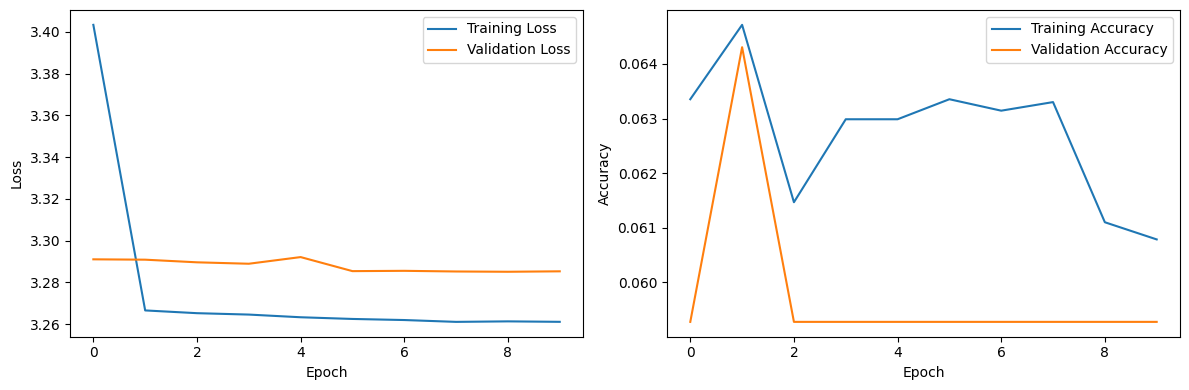

In [41]:
# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()